# Question 1
---

$\textbf{Stochastic Processes}$

A stochastic process is a collection of random variables indexed by time ($t \in \mathbb{R}$) or space ($x \in \mathbb{R}^d$) that describes how a system evolves in a probabilistic way. For example, the daily closing prices of a stock is a temporal stochastic process because it fluctuates randomly over time. The temperature at different locations in a region can be a spatial stochastic process.

$\textbf{Gaussian Processes}$

A Gaussian Process (GP) is a specific type of stochastic process where any finite collection of its random variables follows a multivariate Gaussian (normal) distribution. This property makes GPs particularly powerful and tractable. A GP can be thought of as a distribution over functions, defined by two things: a mean function $m(x)$ which gives the expected value at each point $x$, and a covariance function $k(x_i,x_j)$ which describes correlation between values at points $x_i$ and $x_j$.

$\textbf{Variational Inferece}$

Variational inference is a technique used to approximate complex probability distributions, particularly posterior distributions that are difficult to compute directly. It uses Bayes' Theorem but deals with the normalizing constant by a simpler, parameterized distribution $q(\theta)$, called the variational distribution, which gets optimized by minimizing KL-divergence between it and the posterior.

$\textbf{Evidence Lower Bound}$

Evidence Lower Bound (ELBO) is used in variational inference as a way to deal with $p(D)$, where $D$ is the data. We have

$$\log p(D) = \log \int p(D|\theta)p(\theta)d\theta$$

Using $q(\theta)$, we can write

$$\log p(D) \geq E_{q(\theta)}\log(p(D|\theta)) - \text{KL}(q(\theta) \Vert p(\theta))$$

$E_{q(\theta)}\log(p(D|\theta))$ measures how well the model fits the data under the variational distribution. $\text{KL}(q(\theta) \Vert p(\theta))$, acting as a "regularizer", encourages $q(\theta)$ to stay close to the prior $p(\theta)$. Maximizing ELBO increases log likelihood and minimizes KL-divergence.

# Question 2
---

A Gaussian Process (GP) is a collection of random variables, any finite subset of which follows a multivariate normal distribution. In the context of regression, a GP defines a prior over functions $f(x)$ where $f(x) \sim \text{GP}(m(x),k(x,x'))$. $m(x)$ is the mean function and $k(x,x')$ is the covariance function. 

In GP regression, we observe data $(x_i,y_i)$ for $i = 1, \ldots, n$ where $y_i = f(x_i) + \epsilon_i$ and $\epsilon_i \sim N(0,\sigma_n)$ is noise. The GP prior, combined with the observed data, allows us to compute the posterior distribution over functions, which we can use to make predictions at new points $x_*$. 

Let's create a synthetic dataset representing the average daioly temperature in a city over a year. We'll use a sinusoidal function to capture seasonality and put some noise to the data as well. $x$ will be the day of the year, ranging from $1$ to $365$. $y$ will be temperature in Celsius, modeled as

$$y = 15 + 10\sin\left(\frac{2\pi x}{265}\right) + \epsilon$$

where $\epsilon \sim N(0,1)$.

We added standardization of X_obs and X_full to have mean 0 and standard deviation 1. This improves numerical stability in the kernel computation and can make the posterior geometry easier for NUTS to explore.

In [29]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(10)

# Step 1: Generate synthetic temperature data
n_days = 365
X_full = np.linspace(1, n_days, n_days)  # All days of the year, shape (365,)
# True temperature: seasonal pattern + noise
true_temp = 15 + 10 * np.sin(2 * np.pi * X_full / 365)
# Observe a subset of 50 days
n_obs = 50
X_obs_idx = np.random.choice(n_days, n_obs, replace=False)
X_obs = X_full[X_obs_idx].reshape(-1, 1)  # Reshape for GP (n_obs, 1)
y_obs = true_temp[X_obs_idx] + np.random.normal(0, 1, n_obs)  # Add noise

To define the GP model, we use the following hyperparameters:
- length_scale controls the smoothness of the function. A larger length scale means the function varies more slowly.
- sigma is the amplitude of the kernel (aka covariance function), controlling the overall variance of the function.
- noise is the standard deviation of the observation noise.
For the covariance function, we use the Radial Basis Function (RBF) kernel, defined as 

$$k(x,x') = \sigma^2\exp\left(-\frac{\Vert x - x'\Vert^2}{2l^2}\right)$$

where $\sigma^2$ is variance and $l$ is the length scale. 

The marginal GP regression is implemented with pm.gp.Marginal. The marginal_likelihood method defines the likelihod of the obserbed data under the GP prior.

We use pm.sample to sample from the posterior distribution of teh hyperparameters (lengthscale, sigma, noise) and the latent function $f$.

In [33]:
#Step 2: Define the Gaussian Process model in PyMC
with pm.Model() as model:
    # Hyperparameters for the kernel
    length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    noise = pm.HalfNormal("noise", sigma=1)

    # Define the covariance function (RBF kernel)
    cov_func = sigma**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=length_scale)

    # Define the Gaussian Process
    gp = pm.gp.Marginal(cov_func=cov_func)

    # Add noise to the GP (for the likelihood)
    y_ = gp.marginal_likelihood("y", X=X_obs, y=y_obs, noise=noise)

    # Step 3: Sample from the posterior
    trace = pm.sample(1000, tune=500, return_inferencedata=False)

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [length_scale, sigma, noise]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 70 seconds.


We use gp.conditional to compute the posterior predictive distribution of the function $f$ at all $365$ days (X_pred). pm.sample_posterior_predictive generates samples from the posterior predictive distribution, which we use to compute the mean and uncertainty of the predictions.

In [19]:
# Step 4: Predict at all days (X_full)
X_pred = X_full.reshape(-1, 1)  # Reshape for GP (n_days, 1)
with model:
    # Compute the posterior predictive distribution
    f_pred = gp.conditional("f_pred", X_pred)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"], samples=4000)

Sampling: [f_pred]


To visualize our results, we show the following:
- The true temperature (black dashed line).
- The observed data points (Red dots).
- The GP mean prediction (blue line).
- The 95% credible interval representing the uncertainty in prediction (blue shaded area).

In [43]:
# Step 5: Visualize the results
# Extract predictive samples
f_pred_samples = pred_samples["posterior_predictive"]["f_pred"]
f_pred_samples = np.concatenate(f_pred_samples, axis=0)
print("f_pred_samples shape:", f_pred_samples.shape)  # Should be (4000, 365)
mean_pred = f_pred_samples.mean(axis=0)  # (365,)
std_pred = f_pred_samples.std(axis=0)    # (365,)
print("mean_pred shape:", mean_pred.shape)  # Should be (365,)
print("std_pred shape:", std_pred.shape)  # Should be (365,)
print("X_full shape:", X_full.shape)  # Should be (365,)

f_pred_samples shape: (4000, 365)
mean_pred shape: (365,)
std_pred shape: (365,)
X_full shape: (365,)


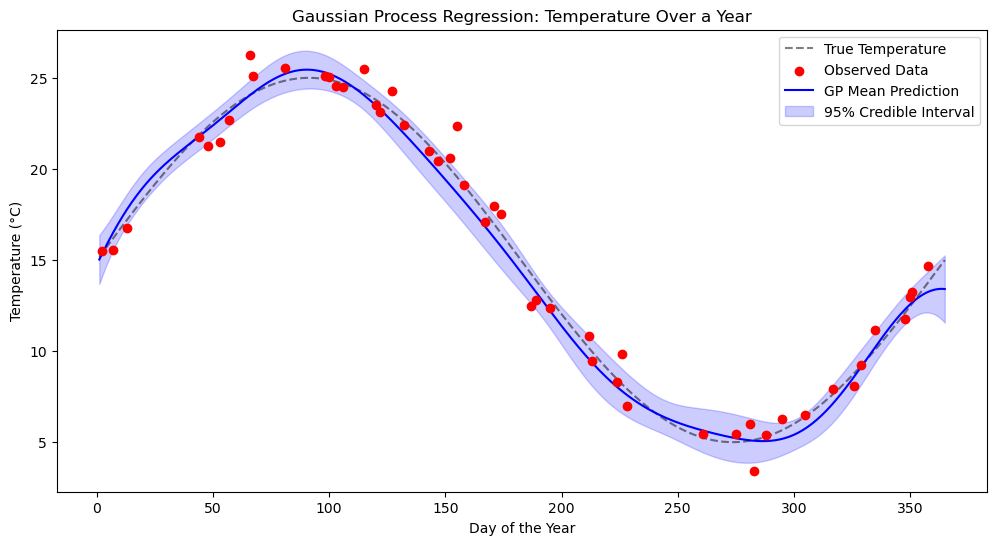

In [44]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_full, true_temp, "k--", label="True Temperature", alpha=0.5)
plt.scatter(X_obs, y_obs, c="red", label="Observed Data", zorder=5)
plt.plot(X_full, mean_pred, "b-", label="GP Mean Prediction")
plt.fill_between(
    X_full,
    mean_pred - 2 * std_pred,
    mean_pred + 2 * std_pred,
    color="blue",
    alpha=0.2,
    label="95% Credible Interval",
)
plt.xlabel("Day of the Year")
plt.ylabel("Temperature (°C)")
plt.title("Gaussian Process Regression: Temperature Over a Year")
plt.legend()
plt.show()

# Question 3
---

This example demonstrates how to use PyMC to fit a Bayesian neural network to a regression problem using variational inference (VI). We model the relationship between a person’s age and their annual income, a nonlinear relationship that a neural network can capture effectively. Unlike traditional neural networks, a Bayesian neural network places priors on the weights, allowing us to quantify uncertainty in the predictions. We use ADVI to approximate the posterior distribution of the weights by optimizing the Evidence Lower Bound (ELBO), a scalable alternative to MCMC sampling.

The dataset is synthetic, representing ages between 18 and 65 and incomes following a parabolic trend with noise. The example includes data preprocessing with standardization, model definition, variational inference, posterior predictive sampling, and visualization of the results with uncertainty estimates.

Data Generation:
- A synthetic dataset is created with 500 samples, where X represents ages between 18 and 65, and y represents incomes following a parabolic trend with Gaussian noise.
- The inputs (X) and outputs (y) are standardized using StandardScaler to improve neural network performance.

In [79]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as tt  
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Generate synthetic data (age vs. income)
n_samples = 500
# Generate synthetic data: Age between 18 and 65
X = np.random.uniform(18, 65, n_samples)
# True income with a parabolic relationship: 20 + 0.1*(age-40)^2
true_income = 20 + 0.1 * (X - 40)**2
# Observations with added noise
y = true_income + np.random.normal(0, 5, n_samples)

# Reshape X to have shape (n_samples, 1)
X = X.reshape(-1, 1)

# Scale inputs and outputs for better neural net performance
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

Model Definition:
- A neural network with one hidden layer (10 units) is defined using PyMC.
- Weights and biases are given Normal priors with mean 0 and standard deviation 1 to allow flexibility.
- The forward pass uses a tanh activation for the hidden layer and a linear output layer.
- The likelihood is defined as a Normal distribution with the scaled observations.

Variational Inference:
- ADVI is used to approximate the posterior distribution of the weights by optimizing the ELBO.
- The pm.fit method runs for 50,000 iterations, and the ELBO history is plotted to monitor convergence.

Finished [100%]: Average Loss = 201.08


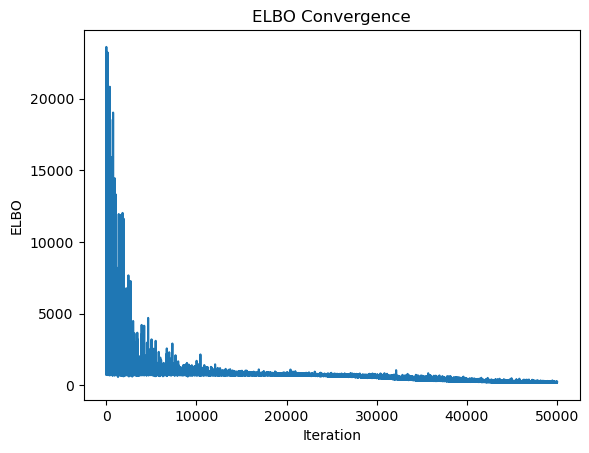

In [110]:
# Step 2: Define the neural network model with PyMC
with pm.Model() as model:
    n_hidden = 10  # Number of hidden units
    
    # Define weights and biases with wide priors to allow flexibility
    w_in_hidden = pm.Normal("w_in_hidden", mu=0, sigma=1, shape=(1, n_hidden))
    b_in_hidden = pm.Normal("b_in_hidden", mu=0, sigma=1, shape=(n_hidden,))
    w_hidden_out = pm.Normal("w_hidden_out", mu=0, sigma=1, shape=(n_hidden, 1))
    b_hidden_out = pm.Normal("b_hidden_out", mu=0, sigma=1, shape=(1,))
    
    # Forward pass through the neural network using tanh activation
    hidden = tt.tanh(tt.dot(X_scaled, w_in_hidden) + b_in_hidden)
    output = tt.dot(hidden, w_hidden_out) + b_hidden_out
    output = tt.flatten(output)  # Ensure output is a 1D vector
    
    # Likelihood using the scaled observations
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=output, sigma=sigma, observed=y_scaled)
    
    # Perform Variational Inference (ADVI)
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

    # Plot the ELBO history to monitor convergence
    plt.plot(approx.hist)
    plt.xlabel("Iteration")
    plt.ylabel("ELBO")
    plt.title("ELBO Convergence")
    plt.show()

Predictions:
- Prediction points are generated and scaled using the same StandardScaler.
- Samples are drawn from the variational posterior using approx.sample.
- For each sample, the neural network forward pass is computed to generate predictions.
- The mean and standard deviation of the predictions are computed in the scaled space and then inverted to the original scale.

In [111]:
# Step 4: Sample from the variational posterior to make predictions
# Generate prediction points
X_pred = np.linspace(18, 65, 100).reshape(-1, 1)
X_pred_scaled = scaler_x.transform(X_pred)
n_samples_pred = 1000

with model:
    # Build the forward pass for predictions
    hidden_pred = tt.tanh(tt.dot(X_pred_scaled, w_in_hidden) + b_in_hidden)
    output_pred = tt.dot(hidden_pred, w_hidden_out) + b_hidden_out
    output_pred = tt.flatten(output_pred)
    
    # Sample from the variational posterior (trace is an InferenceData object)
    trace = approx.sample(n_samples_pred)

In [112]:
# Compute predictions
# Allocate array for prediction samples (shape: [n_samples_pred, n_pred_points])
y_pred_samples = np.zeros((n_samples_pred, X_pred.shape[0]))

# Loop over each posterior sample (select chain=0 and each draw)
for i in range(n_samples_pred):
    w_in_hidden_val = trace.posterior["w_in_hidden"].isel(chain=0, draw=i).values
    b_in_hidden_val = trace.posterior["b_in_hidden"].isel(chain=0, draw=i).values
    w_hidden_out_val = trace.posterior["w_hidden_out"].isel(chain=0, draw=i).values
    b_hidden_out_val = trace.posterior["b_hidden_out"].isel(chain=0, draw=i).values

    # Reshape so dimensions line up
    w_in_hidden_val = w_in_hidden_val.reshape(1, -1)   # (1,10)
    b_in_hidden_val = b_in_hidden_val.reshape(-1)      # (10,)
    w_hidden_out_val = w_hidden_out_val.reshape(-1, 1) # (10,1)
    b_hidden_out_val = b_hidden_out_val.reshape(-1)    # () or (1,)

    hidden_val = np.tanh(np.dot(X_pred_scaled, w_in_hidden_val) + b_in_hidden_val)
    # hidden_val is now (100, 10)

    y_pred_sample = np.dot(hidden_val, w_hidden_out_val).squeeze() + b_hidden_out_val
    # y_pred_sample is (100,)

    y_pred_samples[i] = y_pred_sample
    
# Compute mean and standard deviation in the scaled space
y_pred_mean_scaled = y_pred_samples.mean(axis=0)
y_pred_std_scaled = y_pred_samples.std(axis=0)

# Convert predictions back to original scale
y_pred_mean = scaler_y.inverse_transform(y_pred_mean_scaled.reshape(-1, 1)).flatten()
y_pred_std = scaler_y.inverse_transform(y_pred_std_scaled.reshape(-1, 1)).flatten()

Visualization:
- The observed data, mean prediction, and 95% credible interval are plotted, showing the model’s fit and uncertainty.

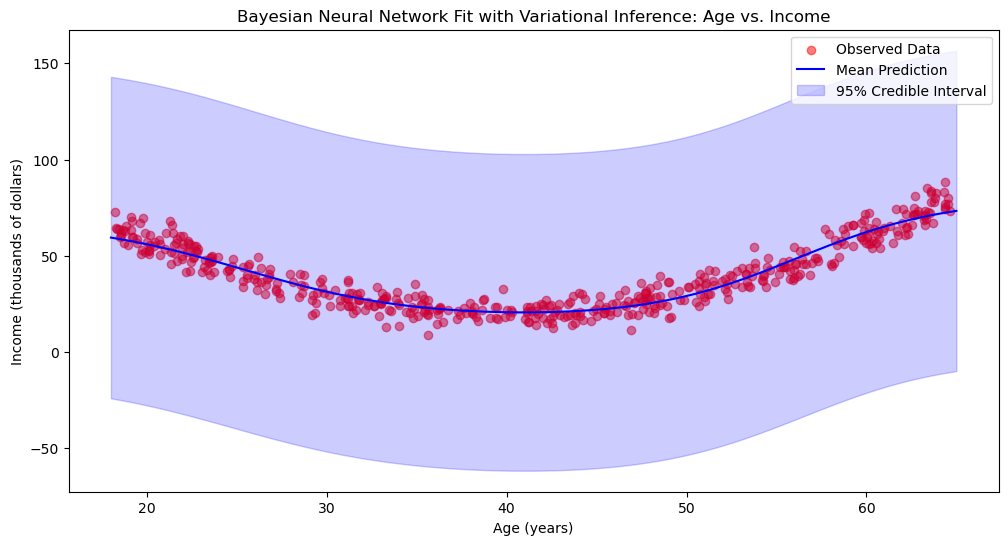

In [113]:
# Step 5: Visualize the results
plt.figure(figsize=(12, 6))
plt.scatter(X, y, c="red", label="Observed Data", alpha=0.5)
plt.plot(X_pred, y_pred_mean, "b-", label="Mean Prediction")
plt.fill_between(
    X_pred.flatten(),
    y_pred_mean - 2 * y_pred_std,
    y_pred_mean + 2 * y_pred_std,
    color="blue",
    alpha=0.2,
    label="95% Credible Interval",
)
plt.xlabel("Age (years)")
plt.ylabel("Income (thousands of dollars)")
plt.title("Bayesian Neural Network Fit with Variational Inference: Age vs. Income")
plt.legend()
plt.show()